In [0]:
import pandas as pd
import numpy as np
import torch
!pip install fastai==0.7.0
!pip install torchtext==0.2.3

import fastai
from fastai.imports import *
from fastai.torch_imports import *
from fastai.core import *
from fastai.model import fit
from fastai.dataset import *

import torchtext
from torchtext import vocab, data
from torchtext.datasets import language_modeling

from fastai.rnn_reg import *
from fastai.rnn_train import *
from fastai.nlp import *
from fastai.lm_rnn import *
from fastai.text import *

import dill as pickle
!pip install spacy
!python -m spacy download en
import spacy
import html

import pickle
import collections
import math
!pip install nbimporter
import nbimporter

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-duvqc178
    100% |████████████████████████████████| 560.1MB 24kB/s 
  Stored in directory: /tmp/pip-ephem-wheel-cache-ps14yyaf/wheels/cf/46/39/b2d08762125ed2376861976ab2c4ac30c029b86e375735d9b8
Successfully built fastai
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: torch 0.3.1
    Uninstalling torch-0.3.1:
      Successfully uninstalled torch-0.3.1
  Found existing installation: fastai 0.7.0
    Uninstalling fastai-0.7.0:
      Successfully uninstalled fastai-0.7.0
  Using cached https://files.pythonhosted.org/packages/50/6d/9d0d6e17a78b0598d5e8c49a0d03ffc7ff265ae62eca3e2345fab14edb9b/fastai-0.7.0-py3-none-any.whl
    100% |████████████████████████████████| 496.4MB 34kB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: torch 1.0.1
    Uninstalling t


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

  Stored in directory: /root/.cache/pip/wheels/44/7d/40/f48fe3f0995a282d582ca73a6807b9bb23c8cc3f1525e62429
Successfully built nbimporter


In [0]:
## DATA CLEANING AND TOKENIZATION


# define paths and load data
clas_path = Path('clas')
lm_path   = Path('lm')
my_data   = pd.read_csv('datasets/us_airline.csv')

y = my_data.airline_sentiment
x = my_data.text

## classification
# create training and validation sets
trn_texts,val_texts, trn_labels, val_labels = sklearn.model_selection.train_test_split(
                                              x, y, test_size = 0.2,
                                              random_state = 41)

trn_texts  = np.array(trn_texts)
trn_labels = np.array(trn_labels)
val_texts  = np.array(val_texts)
val_labels = np.array(val_labels)


# randomize order
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))


# reorder texts
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]


# reorder labels 
trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]


# create dataframe
col_names = ['labels','text']
df_trn    = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns = col_names)
df_val    = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns = col_names)


# save training and validation dataset
classes = ['Positive', 'Negative', 'Neutral']
df_trn.to_csv(clas_path/'train.csv', header = False, index = False)
df_val.to_csv(clas_path/'test.csv', header = False, index = False)
(clas_path/'classes.txt').open('w').writelines(f'{o}\n' for o in classes)


## language model
# create training and validation sets
trn_texts, val_texts = sklearn.model_selection.train_test_split(
                     np.concatenate([trn_texts,val_texts]), test_size = 0.1,
                     random_state = 43)


# saving training and validation dataset
df_trn = pd.DataFrame({'text':trn_texts, 'labels':
                       [0]*len(trn_texts)}, columns = col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':
                       [0]*len(val_texts)}, columns = col_names)

df_trn.to_csv(lm_path/'train.csv', header = False, index = False)
df_val.to_csv(lm_path/'test.csv', header = False, index = False)

In [0]:
from functions import Prep

# tokenization
chunksize = 5000
BOS       = 'xbos'  # beginning-of-sentence tag
df_trn    = pd.read_csv(lm_path/'train.csv', header = None, chunksize = chunksize)
df_val    = pd.read_csv(lm_path/'test.csv', header = None, chunksize = chunksize)

tok_trn, trn_labels = Prep.get_all(df_trn, 1)
tok_val, val_labels = Prep.get_all(df_val, 1)

# save tokenization
np.save(lm_path/'tok_trn.npy', tok_trn)
np.save(lm_path/'tok_val.npy', tok_val)

0
1
2
0


In [0]:
# limit vocabulary
max_vocab = 60000
min_freq  = 2

freq = Counter(p for o in tok_trn for p in o)


# create translation from integer to string and string to integer
itos = [o for o,c in freq.most_common(max_vocab) if c > min_freq]
itos.insert(0, '_unk_')
itos.insert(1, '_pad_')

stoi = collections.defaultdict(lambda:0, 
                               {v:k for k,v in enumerate(itos)})


# tweets expressed as integers
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])


# save dictionary
np.save(lm_path/'trn_ids.npy', trn_lm)
np.save(lm_path/'val_ids.npy', val_lm)
pickle.dump(itos, open(lm_path/'itos.pkl', 'wb'))

In [0]:
## PRETRAINED LANGUAGE MODEL


# set model parameters
em_sz, nh, nl = 400, 1150, 3


# load itos and stoi from the pretrained Wikitext language model
with open('wt103/itos_wt103.pkl', 'rb') as pickle_file:
    itos_wiki = pickle.load(pickle_file)
    
stoi_wiki = collections.defaultdict(lambda: -1, {v:k for k,v 
                                              in enumerate(itos_wiki)})

lm_wgts_wiki = torch.load('wt103/fwd_wt103.h5', map_location = lambda storage, 
                  loc: storage)


# match tokens between the two vocabularies
enc_wgts = lm_wgts_wiki['0.encoder.weight'].numpy()
row_m    = np.mean(enc_wgts, axis = 0)

new_wm = np.zeros((len(itos), em_sz), dtype = np.float32)
for i,w in enumerate(itos):
    r  = stoi_wiki[w]
    new_wm[i] = enc_wgts[r] if r >= 0 else row_m
    
lm_wgts_wiki['0.encoder.weight']                    = T(new_wm)
lm_wgts_wiki['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_wm))
lm_wgts_wiki['1.decoder.weight']                    = T(np.copy(new_wm))

In [0]:
wd   = 1e-7
bptt = 70
bs   = 64
t    = len(np.concatenate(trn_lm))


# define optimizer and create data loader 
opt_fn  = partial(optim.Adam, betas = (0.8, 0.99))
trn_dl  = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl  = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)

In [0]:
## CREATE MODEL ARCHITECTURE


md = LanguageModelData('', pad_idx = 1, n_tok = len(itos), trn_dl = trn_dl, val_dl = val_dl, bs = bs, 
                       bptt = bptt)

# define droupout parameters and create model architecture
drops   = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
learner = md.get_model(opt_fn, em_sz, nh, nl, 
          dropouti = drops[0], dropout = drops[1], wdrop = drops[2],
          dropoute = drops[3], dropouth = drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [0]:
# load model weights from pretrained wikipedia model
learner.model.load_state_dict(lm_wgts_wiki)


# set initial learning rate
lr  = 1e-3


# fit model with frozen lstm for one epoch
learner.fit(lr, 1, wds = wd, use_clr = (32,2), cycle_len = 1) 

epoch      trn_loss   val_loss   accuracy   
    0      6.254568   5.924486   0.118115  



[array([5.92449]), 0.11811501228305847]

 97%|█████████▋| 64/66 [00:26<00:00,  2.64it/s, loss=26.8]

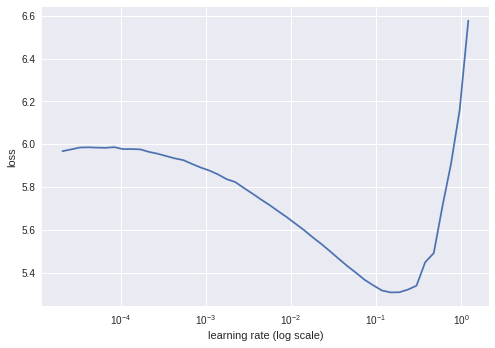

In [0]:
# save learner for further training
learner.save('lm_last_ft')


# unfreeze all layers
learner.unfreeze()


# perform and plot algorithm to find optimal learning rate
learner.lr_find(lr/1000)
learner.sched.plot()

In [0]:
learner.load('lm_last_ft')


# set discriminative learning rate
lr  = 1e-2
lrm = 2.6
lrs = np.array([lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])


# fit model with unfrozen lstm layers until it overfits
learner.fit(lrs, 1, wds = wd, use_clr = (20,10), cycle_len = 3)

epoch      trn_loss   val_loss   accuracy   
    0      4.336937   3.914854   0.274203  
    1      3.92364    3.78316    0.288591  
    2      3.69587    3.764121   0.291678  


[array([3.76412]), 0.2916783712553174]

In [0]:
# save complete model and encoder
learner.save('lm2')
learner.save_encoder('lm2_enc')

In [0]:
## DATA PREPARATION FOR CLASSIFIER

# tokenize saved training and validation datasets
df_trn = pd.read_csv(clas_path/'train.csv', header = None, chunksize = chunksize)
df_val = pd.read_csv(clas_path/'test.csv', header = None, chunksize = chunksize)

tok_trn, trn_labels = Prep.get_all(df_trn, 1)
tok_val, val_labels = Prep.get_all(df_val, 1)


(clas_path/'tmp').mkdir(exist_ok = True)
np.save(clas_path/'tmp'/'tok_trn.npy', tok_trn)
np.save(clas_path/'tmp'/'tok_val.npy', tok_val)
np.save(clas_path/'tmp'/'trn_labels.npy', trn_labels)
np.save(clas_path/'tmp'/'val_labels.npy', val_labels)
tok_trn = np.load(clas_path/'tmp'/'tok_trn.npy')
tok_val = np.load(clas_path/'tmp'/'tok_val.npy')

0
1
2
0


In [0]:
# load vocabulary from language model
itos = pickle.load((lm_path/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in 
                                          enumerate(itos)})

In [0]:
# encode tokens
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])
np.save(clas_path/'tmp'/'trn_ids.npy', trn_clas)
np.save(clas_path/'tmp'/'val_ids.npy', val_clas)

In [0]:
trn_clas   = np.load(clas_path/'tmp'/'trn_ids.npy')
val_clas   = np.load(clas_path/'tmp'/'val_ids.npy')
trn_labels = np.load(clas_path/'tmp'/'trn_labels.npy')
val_labels = np.load(clas_path/'tmp'/'val_labels.npy')

In [0]:
# set hyperparameters
bptt, nh   = 70, 1150 
em_sz, nl  = 400, 3
bs, c      = 64, 3
vs         = len(itos)

opt_fn = partial(optim.Adam, betas = (0.8, 0.99))

In [0]:
## CREATE MODEL ARCHITECTURE

import functions as fct

# function using sampler and data loader from fastai library
md = fct.data_loader('', trn_clas, val_clas, trn_labels, val_labels, bs = bs, pad_idx = 1)


# define droupout parameters and create model architecture
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.4])*0.7
m   = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz = em_sz, n_hid = nh, 
                        n_layers = nl, pad_token = 1,
                        layers   = [em_sz*3, 50, c], drops = [dps[4], 0.1],
                        dropouti = dps[0], wdrop = dps[1],        
                        dropoute = dps[2], dropouth = dps[3])

In [0]:
# build rnn classifier model
learn         = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn = opt_fn)
learn.reg_fn  = partial(seq2seq_reg, alpha = 2, beta = 1)
learn.clip    = .25
learn.metrics = [accuracy]

In [0]:
# set discriminative learning rate
lr  = 3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [0]:
# set weight decay and load encoder from language model
wd = 1e-7
learn.load_encoder('lm2_enc')

 90%|████████▉ | 164/183 [00:10<00:01, 18.72it/s, loss=3.58]

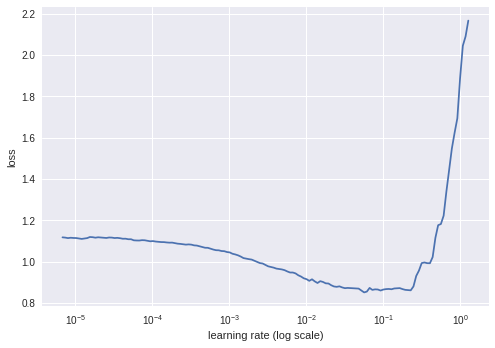

In [0]:
# freeze lstms and relu layer
learn.freeze_to(-1)


# perform and plot algorithm to find optimal learning rate
learn.lr_find(lrs/1000)
learn.sched.plot()

In [ ]:
# readjust discriminative learning rate if necessary
lr  = 3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [0]:
# fit frozen model for one epoch
learn.fit(lrs, 1, wds = wd, cycle_len = 1, use_clr = (8,3))
learn.save('clas_0')

epoch      trn_loss   val_loss   accuracy   
    0      0.702173   0.50605    0.807647  


In [0]:
learn.load('clas_0')


# unfreeze relu layer and fit another epoch
learn.freeze_to(-2)
learn.fit(lrs, 1, wds = wd, cycle_len = 1, use_clr = (8,3))

learn.save('clas_1')

epoch      trn_loss   val_loss   accuracy   
    0      0.614546   0.477427   0.811608  


epoch      trn_loss   val_loss   accuracy   
    0      0.610558   0.464401   0.824032  
    1      0.559193   0.442491   0.82868   
    2      0.536616   0.444981   0.832437  
    3      0.46849    0.450206   0.836763  
    4      0.419308   0.441725   0.841484  


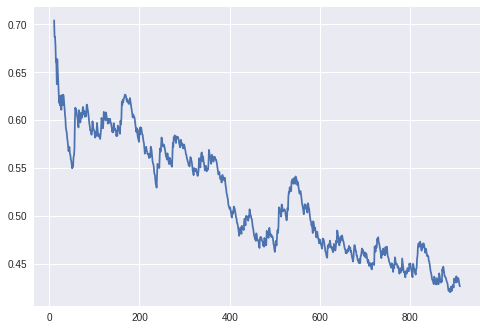

In [0]:
learn.load('clas_1')


# unfreeze all layers and execute final fit
learn.unfreeze()
learn.fit(lrs, 1, wds = wd, cycle_len = 5, use_clr = (32,10))


learn.sched.plot_loss()
learn.save('clas_2')

In [0]:
# load trained classifier for prediction on other dataset
learn.load('clas_2')

In [0]:
# load GOP Debate twitter dataset
my_test = pd.read_csv('datasets/gop_debate.csv')


y = my_test.sentiment
x = my_test.text

In [0]:
test_texts  = np.array(x)
test_labels = np.array(y)


# create dataframe
col_names = ['labels','text']
df_test   = pd.DataFrame({'text':test_texts, 'labels':test_labels}, columns=col_names)
df_test.to_csv('prediction/test_final.csv', header = False, index = False)

In [0]:
chunksize = 5000
BOS = 'xbos'
df_test = pd.read_csv('prediction/test_final.csv', 
                      header = None, chunksize = chunksize)

#tokenize dataset
tok_test, test_labels = Prep.get_all(df_test, 1)

0
1
2


In [0]:
# encode tokens
test_clas = np.array([[stoi[o] for o in p] for p in tok_test])
test_clas

array([list([2, 3, 407, 0, 88, 78, 93, 432, 660, 96, 7, 0, 150, 511, 152, 286, 10, 1262, 4, 0]),
       list([2, 3, 407, 0, 88, 93, 28, 1019, 7, 419, 0, 152, 286, 4, 163, 48, 225, 27, 3498, 37, 230, 972, 23, 927, 2081, 4, 0, 754]),
       list([2, 3, 407, 0, 88, 36, 1203, 27, 0, 0, 18, 7, 0, 33, 875, 23, 1971, 10, 653, 4]), ...,
       list([2, 3, 407, 0, 88, 0, 104, 3956, 13, 6, 65, 352, 287, 7, 2717, 13, 18, 39, 61, 6, 243, 6, 82, 39, 4, 0]),
       list([2, 3, 407, 0, 88, 0, 0, 0, 276, 30, 248, 127, 28, 32, 64, 14, 0, 0, 4, 78, 127, 453, 2229, 55, 2462, 0, 55, 1273, 520, 754]),
       list([2, 3, 407, 0, 88, 0, 1112, 256, 7, 0, 0, 4, 148, 8, 0, 9, 9, 861, 0])], dtype=object)

In [0]:
# arrange dataset for prediction
test_ds = TextDataset(test_clas, test_labels)
dl_test = DataLoader(test_ds, bs, transpose = True, num_workers = 1, 
                     pad_idx = 1)

In [0]:
# prediction
pred_test = learn.predict_dl(dl_test)
counter   = 0
for i in range(0, len(test_labels)): 
        pred_test2  = pred_test[i]
        pred_aslist = pred_test2.tolist()
        probs       = fct.softmax(pred_aslist)
        idx,        = np.where(probs == np.amax(probs))
        if test_labels[i] == idx:
                  counter = counter + 1
            
            
# print out accuracy
print('Accuracy: ' + str(counter/len(test_labels)))

Accuracy: 0.5103453247783145
